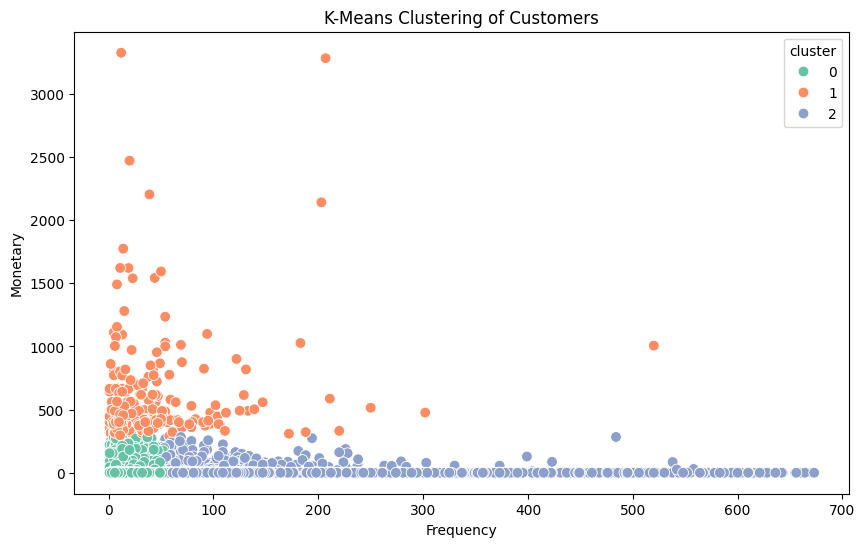

cluster
0    615565
2     22343
1       264
Name: count, dtype: int64


In [6]:
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

from collections import defaultdict

import warnings

warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# 데이터 불러오기
# Parquet 파일 열기
table = pq.read_table('../data/train.parquet')

# pandas DataFrame으로 변환
data = table.to_pandas() 

def is_purchase(x):
    if x =='purchase':
        return 1
    else:
        return 0

data.loc[:,'is_purchase'] = data['event_type'].apply(is_purchase)
data.loc[:,'purchase_price'] = data.loc[:,'is_purchase'] * data.loc[:,'price']

# 유저별 Frequency (상호작용 횟수)와 Monetary (구매한 금액)
user_data = data.groupby('user_id').agg({
    'item_id': 'count',  # Frequency: 아이템과의 상호작용 횟수
    'purchase_price': 'sum'       # Monetary: 사용자가 지출한 금액
}).reset_index()

user_data.columns = ['user_id', 'frequency', 'monetary']

# IQR을 사용하여 극단적인 값 제거
Q1 = user_data['frequency'].quantile(0)
Q3 = user_data['frequency'].quantile(0.999)
IQR = Q3 - Q1

# IQR 범위 내의 값만 선택 (극단 값 제거)
user_data_cleaned = user_data[(user_data['frequency'] <= Q3 + 1.5 * IQR)]

# IQR을 사용하여 극단적인 값 제거
Q1 = user_data['frequency'].quantile(0)
Q3 = user_data['frequency'].quantile(0.999)
IQR = Q3 - Q1

# IQR 범위 내의 값만 선택 (극단 값 제거)
user_data_cleaned = user_data[(user_data['frequency'] <= Q3 + 1.5 * IQR)]

# K-Means 클러스터링 적용
kmeans = KMeans(n_clusters=3, n_init=10)
user_data_cleaned['cluster'] = kmeans.fit_predict(user_data_cleaned[['frequency', 'monetary']])

# 클러스터링 결과 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='frequency', y='monetary', hue='cluster', data=user_data_cleaned, palette='Set2', s=60)

# 그래프 제목 및 레이블 설정
plt.title('K-Means Clustering of Customers')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.legend(title='cluster')
plt.show()

print(user_data_cleaned['cluster'].value_counts())


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8350311 entries, 0 to 8350310
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         object 
 1   item_id         object 
 2   user_session    object 
 3   event_time      object 
 4   category_code   object 
 5   brand           object 
 6   price           float64
 7   event_type      object 
 8   is_purchase     int64  
 9   purchase_price  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 700.8+ MB


In [9]:
out_index = user_data[(user_data['frequency'] > Q3 + 1.5 * IQR)].index
user_data.loc[out_index,'cluster']=4
user_data.loc[user_data_cleaned.index,'cluster']=user_data_cleaned.loc[:,'cluster']

user_data

,user_id,frequency,monetary,cluster
0,0000162d-72b9-4b0f-8895-7b52b6661c82,28,0.0,0.0
1,00001710-fd5d-47e4-aecb-8da4173a7c02,1,0.0,0.0
2,00002da8-29b8-4d15-bf99-b4b4475e4631,11,0.0,0.0
3,00002dee-c493-4ad7-b7e1-093f572b0e75,5,0.0,0.0
4,0000334c-aad3-4036-a746-b05a4a5896a7,2,0.0,0.0
...,...,...,...,...
638252,ffff60a4-eed8-439b-9741-6d5e57214199,12,0.0,0.0
638253,ffff7f5c-25ea-4844-a1f8-dcadc9d4a105,9,0.0,0.0
638254,ffffa0d0-d3fe-4098-a8fb-f8dccff0709d,8,0.0,0.0
638255,ffffc371-aee8-4d93-9327-fdb777037789,9,0.0,0.0


In [10]:
new_data = data.merge(user_data,on='user_id',how='inner')
# event_time에서 month 추출
new_data['event_month'] = pd.to_datetime(data['event_time']).dt.month

# # Train 데이터: 11, 12, 1월, Validation 데이터: 2월
# train_data = new_data[new_data['event_month'].isin([11, 12, 1])]
# valid_data = new_data[new_data['event_month'] == 2]

train_data = new_data.copy()

size = new_data['event_type'].value_counts()
size.values[0]

# 비율 기반 가중치 (역수)
view_weight_inverse = 1 / size.values[0]
cart_weight_inverse = 1 / size.values[1]
purchase_weight_inverse = 1 / size.values[2]

# 정규화된 역수 기반 가중치
total_weight_inverse = view_weight_inverse + cart_weight_inverse + purchase_weight_inverse
normalized_view_weight = view_weight_inverse / total_weight_inverse
normalized_cart_weight = cart_weight_inverse / total_weight_inverse
normalized_purchase_weight = purchase_weight_inverse / total_weight_inverse
print("======Weight======")
print('    view weight: ',normalized_view_weight)
print('    cart weight: ',normalized_cart_weight)
print('purchase weight: ',normalized_purchase_weight)

# 사용자-아이템 상호작용 기반으로 가중치 부여 (view, cart, purchase)
event_weight = {'view': normalized_view_weight, 'cart': normalized_cart_weight, 'purchase': normalized_purchase_weight}
train_data.loc[:, 'event_weight'] = train_data['event_type'].map(event_weight)

def current_month_interaction(x):
    if x==2:
        return 1
    else:
        return 0

def is_purchase(x):
    if x =='purchase':
        return 1
    else:
        return 0

def is_50(x):
    if x<=50:
        return 5
    else:
        return 2

def type_weight(x):
    if x in ['cart','view']:
        return 5
    else:
        return 0

train_data.loc[:,'current_month_interaction'] = train_data['event_month'].apply(current_month_interaction)
train_data.loc[:,'is_purchase'] = train_data['event_type'].apply(is_purchase)
train_data.loc[:,'is_50'] = train_data['price'].apply(is_50)
train_data.loc[:,'type_weight'] = train_data['event_type'].apply(type_weight)
train_data.loc[:,'2_cartview'] = train_data['type_weight']*train_data['current_month_interaction']
train_data.loc[:,'2_purchase'] = train_data['is_purchase'] * train_data['current_month_interaction'] * train_data['is_50']
train_data.loc[:,'date_weight'] = train_data.loc[:,'2_cartview'] + train_data.loc[:,'2_purchase']

# 사용자별, 아이템별로 가중치 합산
user_item_weights = train_data.groupby(['user_id', 'item_id']).agg({
    'event_weight': 'sum',  # 예시: 가중치를 합산
    'brand': 'first',  # 아이템의 브랜드는 동일하다고 가정하고 첫 번째 값을 사용
    'price': 'mean',
    'date_weight': 'max',
    'frequency' : 'first',
    'monetary' : 'first',
    'cluster' :'first',
}).reset_index()

======Weight======
    view weight:  0.0002210605617749748
    cart weight:  0.11256866678998563
purchase weight:  0.8872102726482393


In [11]:
from sklearn.preprocessing import LabelEncoder

# 데이터 준비 (train_data가 미리 준비되어 있다고 가정)

# 브랜드 인코딩 (brand를 정수로 변환)
label_encoder = LabelEncoder()
user_item_weights['brand_encoded'] = label_encoder.fit_transform(user_item_weights['brand'])

X_train = user_item_weights[['price',	'date_weight',	'frequency',	'monetary',	'cluster',	'brand_encoded']]
y_train = user_item_weights['event_weight']

from xgboost import XGBRegressor
model = XGBRegressor(learning_rate=0.1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

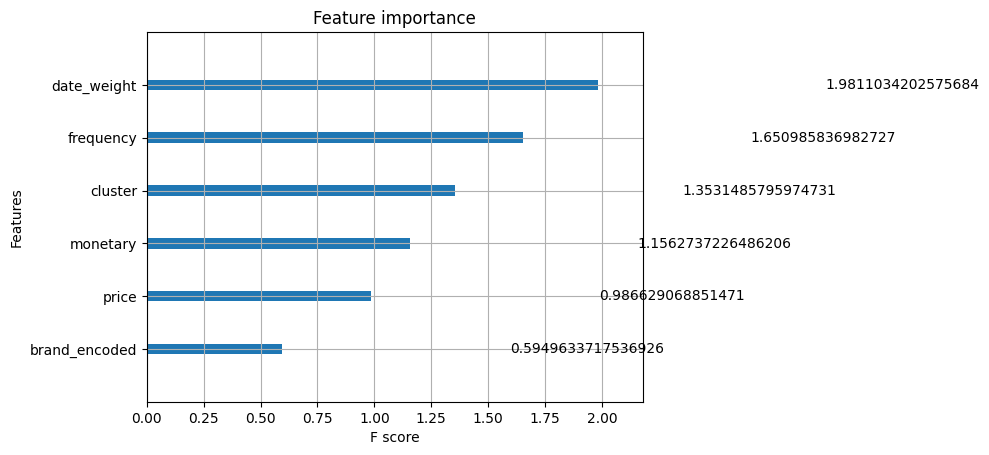

In [12]:
from xgboost import plot_importance

plot_importance(model, max_num_features=10, importance_type ='gain')
plt.rcParams['figure.figsize'] = (40,10)
plt.show()

In [13]:
user_item_weights['date_weight'].describe()

count    5.943059e+06
mean     1.199031e+00
std      2.134773e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.000000e+00
Name: date_weight, dtype: float64

In [14]:
user_item_weights.to_csv('../data/total_train.csv')

,user_id,item_id,event_weight,brand,price,date_weight,frequency,monetary,cluster,brand_encoded
0,0000162d-72b9-4b0f-8895-7b52b6661c82,0bb05529-df13-46ca-8bfc-832344a7b1d3,0.000663,apple,643.23,0,28,0.0,0.0,84
1,0000162d-72b9-4b0f-8895-7b52b6661c82,2a022c08-3dd5-4ca2-a6b4-a0408f96dd77,0.000221,lenovo,167.03,0,28,0.0,0.0,970
2,0000162d-72b9-4b0f-8895-7b52b6661c82,2ffc3538-1e13-4a2a-b979-e813bb640674,0.000221,apple,527.40,0,28,0.0,0.0,84
3,0000162d-72b9-4b0f-8895-7b52b6661c82,35715001-cc23-465f-b940-868348fecbbf,0.000221,huawei,153.93,0,28,0.0,0.0,774
4,0000162d-72b9-4b0f-8895-7b52b6661c82,383fde85-a76b-447d-ab42-0e26e4897420,0.000442,apple,640.92,0,28,0.0,0.0,84
...,...,...,...,...,...,...,...,...,...,...
5943054,ffffc959-2575-476c-b897-057e51182c5f,675083eb-7e33-4815-a3fd-411918cf5b24,0.000221,pt-group,244.54,5,6,0.0,0.0,1369
5943055,ffffc959-2575-476c-b897-057e51182c5f,7c299deb-94cb-4c67-85f9-c71c9b30b1b1,0.000221,pt-group,244.54,5,6,0.0,0.0,1369
5943056,ffffc959-2575-476c-b897-057e51182c5f,b6b56d28-0f9c-4906-93df-cab0532930b8,0.000221,pt-group,231.67,5,6,0.0,0.0,1369
5943057,ffffc959-2575-476c-b897-057e51182c5f,bdc5f1cb-ce06-47d6-9d3f-f98d79bf54e1,0.000221,pt-group,231.67,5,6,0.0,0.0,1369
